# Assessing the effect of a changing sample size on the resilience metrics

In [1]:
%matplotlib inline
from statsmodels.tsa.arima_process import arma_generate_sample
from astropy import stats
from statsmodels.robust.norms import TukeyBiweight
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression
from scipy.stats import skew, skewtest, truncnorm, wilcoxon, normaltest
from scipy.ndimage.filters import gaussian_filter
import sys
import warnings
warnings.filterwarnings("ignore")
sys.path.append('../../lib/')
from regimeshifts import ews

/tmp/ipykernel_1494/1305983106.py:13: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter


In [2]:
def create_inc_n_chron(ts_len=300,min_n=10,max_n=30,min_len=60,last_year=2022,std=1):
    """
    Creates a dataframe with independing white-noise time-series introduced successively
    """
    var_sample_depth = np.round(np.linspace(min_n,max_n,ts_len-min_len),0)
    var_sample_depth = np.concatenate([var_sample_depth,np.tile(max_n,min_len)])
    sample_depth_ts = pd.Series(index=np.arange(last_year-ts_len,last_year),data=var_sample_depth)
    ind_synth_ts = []
    for j,sd in enumerate(np.unique(var_sample_depth)):
        len_ind_ts = len(sample_depth_ts[sample_depth_ts>=sd])
        start_year = sample_depth_ts[sample_depth_ts==sd].idxmax()
        n_ind_meas = min_n if j == 0 else 1
        for rep in range(n_ind_meas):
            ind_ts = pd.Series(index=range(start_year,start_year+len_ind_ts),data=np.random.normal(0,std,len_ind_ts))
            ind_synth_ts.append(ind_ts)
    chron_synth = pd.concat(ind_synth_ts, axis=1, sort=False)
    return chron_synth

In [3]:
iom_shells = pd.read_csv('output/raw_ind_shells_IS_PB.csv',index_col=0)
ice_shells = pd.read_csv('output/raw_ind_shells_ICE_PB.csv',index_col=0)
n_1_to_10 = create_inc_n_chron(ts_len=250,min_n=1,max_n=10,last_year=2023)
n_10_to_30 = create_inc_n_chron(ts_len=250,min_n=10,max_n=30,last_year=2023)

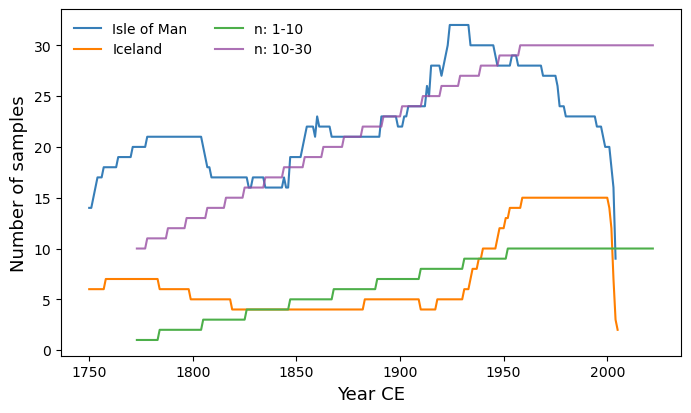

In [4]:
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#984ea3', '#a65628', '#f781bf', 
                  '#999999', '#e41a1c', '#dede00']
year = 1750
plt.close()
fig, axs = plt.subplots(figsize=(8,4.5),facecolor='white')
iom_shells[iom_shells.index>=year].count(axis=1).plot(linewidth=1.5,ax=axs,label='Isle of Man',color=CB_color_cycle[0])
#fg_shells[fg_shells.index>=year].count(axis=1).plot(label='Fladen Ground',ax=axs,color=CB_color_cycle[1])
ice_shells[ice_shells.index>=year].count(axis=1).plot(label='Iceland',ax=axs,color=CB_color_cycle[1])
n_1_to_10.count(axis=1).plot(label='n: 1-10',ax=axs,color=CB_color_cycle[2])
n_10_to_30.count(axis=1).plot(alpha=0.8,ax=axs,label='n: 10-30',color=CB_color_cycle[3])
axs.set_xlabel('Year CE',fontsize=13);
axs.set_ylabel('Number of samples',fontsize=13);
axs.legend(frameon=False,ncol=2);
fig.savefig(f'img/number_samples.jpeg',dpi=300, bbox_inches='tight')
plt.show()

### Minimum EPS vs SNR

In [5]:
iom_rel_eps = pd.read_csv('output/eps_vs_noise_IS_PB_n300.csv',index_col=[0,1])
ice_rel_eps = pd.read_csv('output/eps_vs_noise_ICE_PB_n300.csv',index_col=[0,1])
rel_eps_10_30 = pd.read_csv('output/eps_vs_noise_n_10_to_30_n300.csv',index_col=[0,1])
rel_eps_1_10 = pd.read_csv('output/eps_vs_noise_n_1_to_10_n300.csv',index_col=[0,1])
rel_eps_np_dfs = { 'n_1_to_10':rel_eps_1_10,
                   'n_10_to_30':rel_eps_10_30,
                   'IS_PB':iom_rel_eps,
                   'ICE_PB':ice_rel_eps}

In [6]:
titles = { 'n_1_to_10':'n: 1-10',
           'n_10_to_30':'n: 10-30',
           'IS_PB':'Isle of Man',
           'ICE_PB':'Iceland'}    

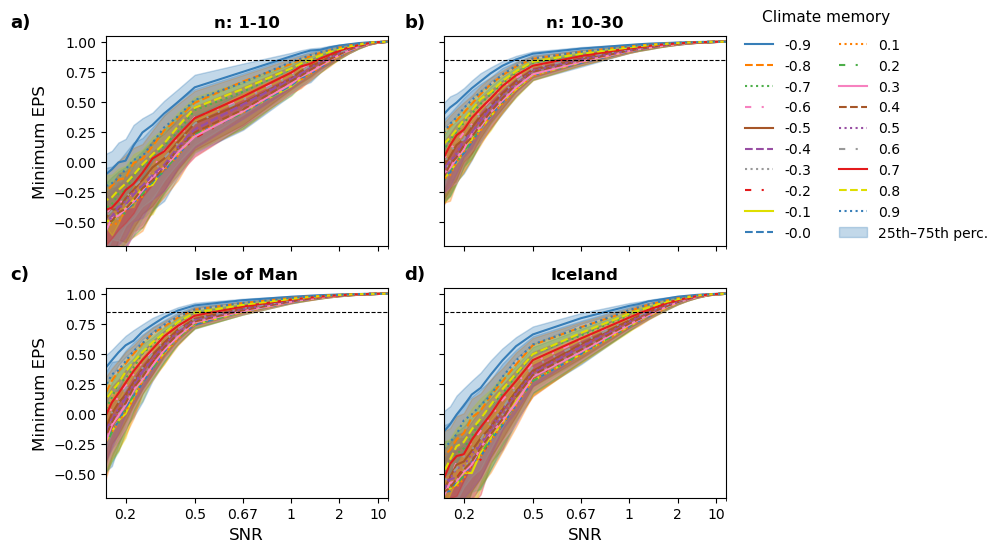

In [7]:
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

map_axs = { 'n_1_to_10':(0,0),'n_10_to_30':(0,1),'IS_PB':(1,0),'ICE_PB':(1,1)}                              
                   
linestyles = ['-', "--", ":",(0, (3, 5, 1, 5, 1, 5))]
plt.close()
fig,axs = plt.subplots(2,2,sharey='row',sharex='col',figsize=(8,6),facecolor='white')
for chid, rel_df in rel_eps_np_dfs.items():
    axi = map_axs[chid]
    median = rel_df.median(axis=1).unstack().T
    stdev = rel_df.std(axis=1).unstack().T
    q025 = rel_df.quantile(0.25,axis=1).unstack().T
    q075 = rel_df.quantile(0.75,axis=1).unstack().T

    for i,col in enumerate(median.columns):
        color = CB_color_cycle[i%len(CB_color_cycle)]
        lstyle = linestyles[i%len(linestyles)]
        median[col].plot(ax=axs[axi],color=color,linestyle=lstyle)
        #axs.fill_between(stdev.index, median[col]-stdev[col],median[col]+stdev[col],alpha=0.3,color='tab:blue')
        if i == len(median.columns)-1:
            axs[axi].fill_between(median.index, q025[col],q075[col],alpha=0.3,color=color,label='25th–75th perc.')
        else:
            axs[axi].fill_between(median.index, q025[col],q075[col],alpha=0.3,color=color)
    axs[axi].set_xlim(median.index.min(),median.index.max());
    axs[axi].set_ylim(-0.7,1.05);
    axs[axi].axhline(0.85,color='k',linestyle="--",linewidth=0.8)
    axs[axi].set_title(titles[chid],weight='bold')
    axs[axi].set_xlabel('SNR',fontsize=12)
    axs[axi].invert_xaxis()
    axs[axi].set_xscale('symlog')
    ticks = [0.1,0.5,1,1.5,2,5]
    axs[axi].set_xticks(ticks)
    axs[axi].set_xticklabels([np.round(1/it,2) if (10/it)%10!=0 else int(1/it)  for it in ticks])    
axs[0,1].legend(loc=(1.05,0),ncol=2,frameon=False)
axs[0,0].set_ylabel('Minimum EPS',fontsize=12);
axs[1,0].set_ylabel('Minimum EPS',fontsize=12);
axs[0,1].text(1.13,1.07,'Climate memory',transform=axs[0,1].transAxes,size=11,horizontalalignment='left')
    
for j in [0,1]:
    x = -0.34 if j == 0 else -0.14
    axs[0,j].text(x,1.04,'ab'[j]+')',transform=axs[0,j].transAxes,size=13,horizontalalignment='left',weight='bold')
for j in [0,1]:
    x = -0.34 if j == 0 else -0.14
    axs[1,j].text(x,1.04,'cde'[j]+')',transform=axs[1,j].transAxes,size=13,horizontalalignment='left',weight='bold')
#fig.delaxes(axs[0,2])
fig.savefig(f'img/Rel_SNR_EPS.png',dpi=300, bbox_inches='tight');
plt.show()

### Trends in the resilience metric under different scenarios

In [8]:
ar1_eps_IoM = pd.read_csv('output/ar1_vs_eps_kv_IS_PB.csv',index_col=[0,1])
var_eps_IoM = pd.read_csv('output/var_vs_eps_kv_IS_PB.csv',index_col=[0,1])
ar1_eps_Ice = pd.read_csv('output/ar1_vs_eps_kv_ICE_PB.csv',index_col=[0,1])
var_eps_Ice = pd.read_csv('output/var_vs_eps_kv_ICE_PB.csv',index_col=[0,1])
ar1_eps_n10_30 = pd.read_csv('output/ar1_vs_eps_kv_n_10_to_30.csv',index_col=[0,1])
var_eps_n10_30 = pd.read_csv('output/var_vs_eps_kv_n_10_to_30.csv',index_col=[0,1])
ar1_eps_n1_10 = pd.read_csv('output/ar1_vs_eps_kv_n_1_to_10.csv',index_col=[0,1])
var_eps_n1_10 = pd.read_csv('output/var_vs_eps_kv_n_1_to_10.csv',index_col=[0,1])

In [9]:
ews_vs_eps_dict = {'n_1_to_10':[ar1_eps_n1_10,var_eps_n1_10],
                   'n_10_to_30':[ar1_eps_n10_30,var_eps_n10_30],
                   'IS_PB':[ar1_eps_IoM,var_eps_IoM],
                   'ICE_PB':[ar1_eps_Ice,var_eps_Ice]}

In [10]:
## Colors obtained from color brewer
cb_friendly_colors = ['#67001f','#b2182b','#d6604d','#f4a582','#fddbc7','#f7f7f7',
                      '#d1e5f0','#92c5de','#4393c3','#2166ac','#053061']
cb_friendly_cmap = colors.LinearSegmentedColormap.from_list("", cb_friendly_colors)

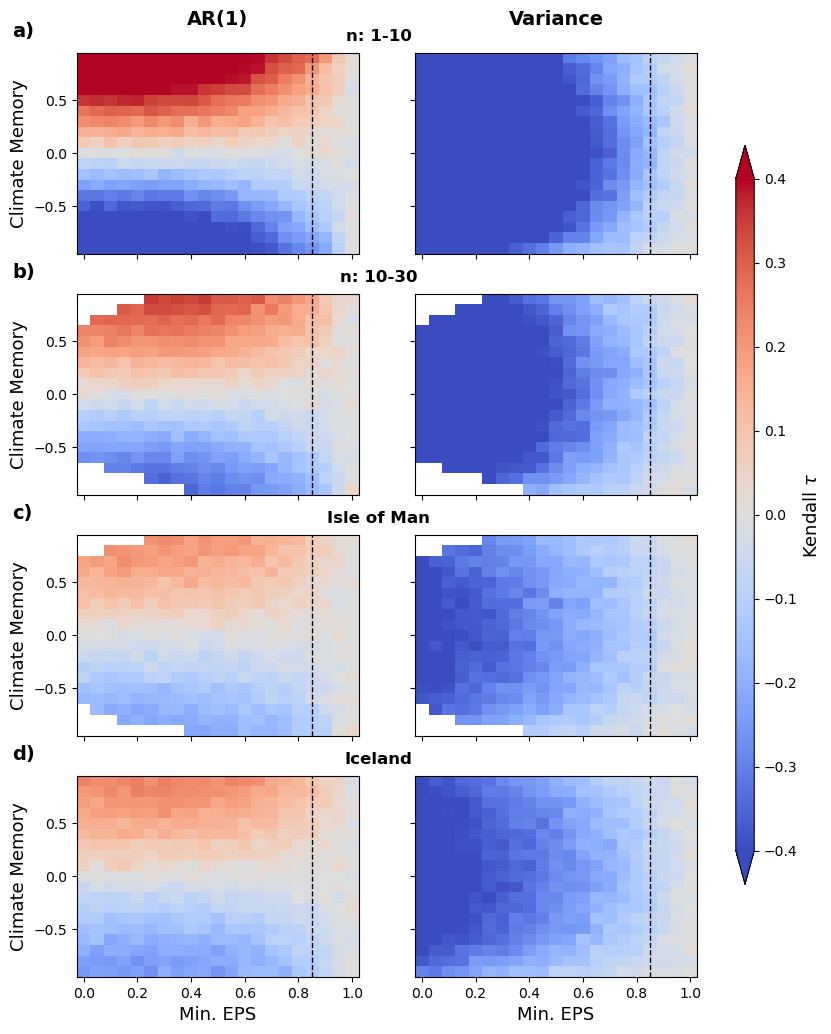

In [12]:
plt.close()
fig, axs = plt.subplots(len(ews_vs_eps_dict),2,figsize=(10,len(ews_vs_eps_dict)*3),sharey='row',sharex='col',facecolor='white')
letters = 'abcde'
for i, (chid,[ar1_ds,var_ds]) in enumerate(ews_vs_eps_dict.items()):

    cm = axs[i,0].pcolormesh(ar1_ds.mean(axis=1).unstack().columns,ar1_ds.mean(axis=1).unstack().index.values,ar1_ds.mean(axis=1).unstack(),
                             vmin=-0.4,vmax=0.4,cmap='coolwarm')
    axs[i,1].pcolormesh(var_ds.mean(axis=1).unstack().columns,var_ds.mean(axis=1).unstack().index.values,var_ds.mean(axis=1).unstack(),
                        vmin=-0.4,vmax=0.4,cmap='coolwarm')
    
    axs[i,0].set_ylabel('Climate Memory',fontsize=13);
    axs[i,0].text(1.07,1.06,titles[chid],transform=axs[i,0].transAxes,horizontalalignment='center',fontsize=12, weight='bold')
    axs[i,0].text(-0.23,1.08,letters[i]+')',transform=axs[i,0].transAxes,fontsize=14, weight='bold')
axs[-1,0].set_xlabel('Min. EPS',fontsize=13);
axs[-1,1].set_xlabel('Min. EPS',fontsize=13);
axs[0,0].set_title('AR(1)',fontsize=14,pad=20,weight='bold');
axs[0,1].set_title('Variance',fontsize=14,pad=20,weight='bold');
[ax.axvline(0.85,color='k',linestyle='--',linewidth='1') for ax in axs.flatten()];
cbar = plt.colorbar(cm,ax=axs,aspect=40,shrink=0.8,extend='both')
cbar.ax.set_ylabel(r'Kendall $\tau$',fontsize=13);
fig.savefig(f'img/EWS_EPS.jpeg',dpi=300, bbox_inches='tight');
plt.show()

In [13]:
var_eps_n1to10_ts = pd.read_csv('output/var_vs_eps_ts_n_1_to_10.csv',index_col=[0,1])
ar1_eps_n1to10_ts = pd.read_csv('output/ar1_vs_eps_ts_n_1_to_10.csv',index_col=[0,1])
var_eps_n10to30_ts = pd.read_csv('output/var_vs_eps_ts_n_10_to_30.csv',index_col=[0,1])
ar1_eps_n10to30_ts = pd.read_csv('output/ar1_vs_eps_ts_n_10_to_30.csv',index_col=[0,1])
var_eps_iom_ts = pd.read_csv('output/var_vs_eps_ts_IS_PB.csv',index_col=[0,1])
ar1_eps_iom_ts = pd.read_csv('output/ar1_vs_eps_ts_IS_PB.csv',index_col=[0,1])
var_eps_ice_ts = pd.read_csv('output/var_vs_eps_ts_ICE_PB.csv',index_col=[0,1])
ar1_eps_ice_ts = pd.read_csv('output/ar1_vs_eps_ts_ICE_PB.csv',index_col=[0,1])

In [14]:
dict_ews_ts = {'n: 1-10':[ar1_eps_n1to10_ts,var_eps_n1to10_ts],
               'n: 10-30':[ar1_eps_n10to30_ts,var_eps_n10to30_ts],
                'Isle of Man':[ar1_eps_iom_ts,var_eps_iom_ts],
               'Iceland':[ar1_eps_ice_ts,var_eps_ice_ts]}
avg_ews_ts = {'n: 1-10':[],
              'n: 10-30':[],
               'Isle of Man':[],
               'Iceland':[]}
for chid, ews in dict_ews_ts.items():
    for j in [0,1]:
        avg_ews_ts[chid].append(ews[j][[str(i) for i in range(1000)]].mean(axis=1))
        avg_ews_ts[chid].append(ews[j][[str(i) for i in range(1000)]].std(axis=1))

In [15]:
year = 1750
sample_size = {'n: 1-10':n_1_to_10.count(axis=1),
               'n: 10-30':n_10_to_30.count(axis=1),
                'Isle of Man':iom_shells[iom_shells.index>=year].count(axis=1),
               'Iceland':ice_shells[ice_shells.index>=year].count(axis=1)}

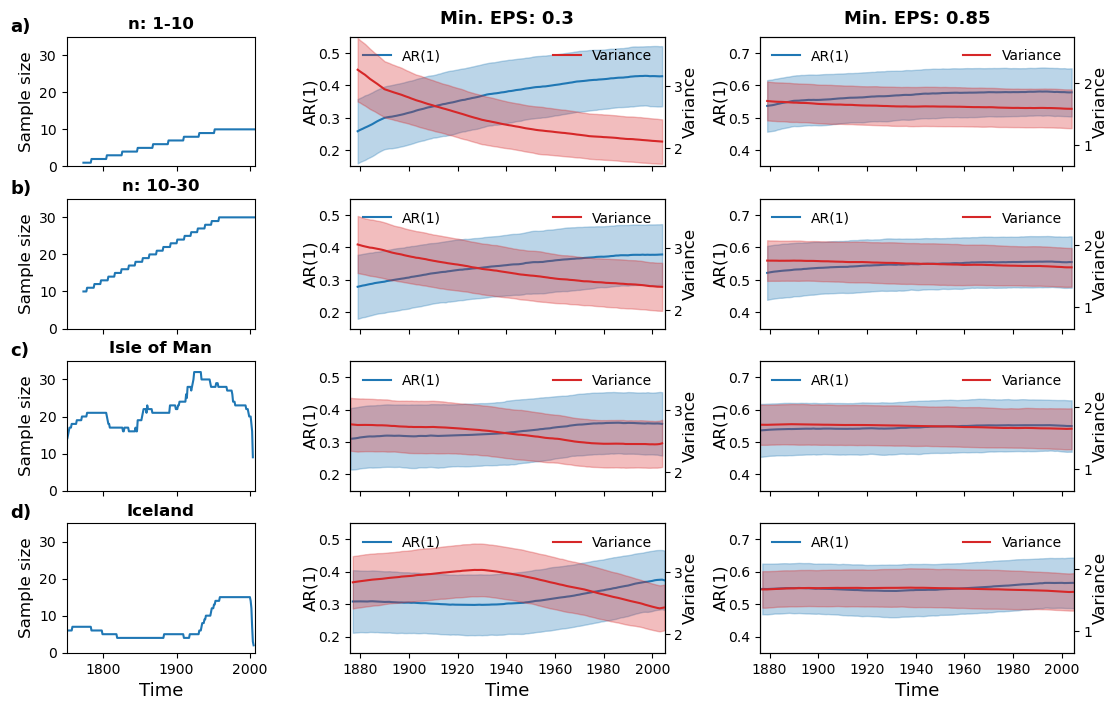

In [16]:
plt.close()
fig, axs = plt.subplots(4,3,figsize=(13,8),sharex='col',gridspec_kw={'width_ratios':[0.6,1,1],'wspace': 0.35,'hspace': 0.25},facecolor='white')

ac1 = 0.7
epss = [0.3, 0.85]
letters = 'abcdef'
for i,(chid,ews_ts) in enumerate(avg_ews_ts.items()):
    years_ts = dict_ews_ts[chid][0].loc[-0.9,0]['Year'].values
    if chid in ['n: 1-10','n: 10-30']:
        years_ts = np.arange(1755,2005)
    for j,eps in enumerate(epss):
        ar1_ts = pd.Series(ews_ts[0].loc[ac1,eps].values)
        ar1_ts.index = years_ts
        ar1_ts = ar1_ts.dropna()
        var_ts = pd.Series(ews_ts[2].loc[ac1,eps].values)
        var_ts.index = years_ts
        var_ts = var_ts.dropna()
        ### Std
        std_ar1 = pd.Series(ews_ts[1].loc[ac1,eps].values)
        std_ar1.index = years_ts
        std_ar1 = std_ar1.dropna()
        std_var = pd.Series(ews_ts[3].loc[ac1,eps].values)
        std_var.index = years_ts
        std_var = std_var.dropna()
        ###         
        ar1_ts.plot(ax=axs[i,j+1],color='tab:blue',label='AR(1)')
        axs[i,j+1].margins(x=0)
        ax2 = axs[i,j+1].twinx()
        var_ts.plot(ax=ax2,color='tab:red',label='Variance')
        axs[i,j+1].fill_between(ar1_ts.index,ar1_ts+std_ar1,ar1_ts-std_ar1,color='tab:blue',alpha=0.3)
        ax2.fill_between(var_ts.index,var_ts+std_var,var_ts-std_var,color='tab:red',alpha=0.3)
        axs[i,j+1].set_ylabel('AR(1)',fontsize=12,labelpad=0);
        ax2.set_ylabel('Variance',fontsize=12,labelpad=0);
        ymin, ymax = axs[i,j+1].get_ylim()
        #axs[i,j+1].set_ylim(ymin,ymax+abs(ymax-ymin)*0.1)
        axs[i,1].set_ylim(0.15,0.55)
        axs[i,2].set_ylim(0.35,0.75)
        ymin, ymax = ax2.get_ylim();
        if j == 0:
            #ax2.set_ylim(ymin,ymax+abs(ymax-ymin)*0.1)
            ax2.set_ylim(1.7,3.8)
        elif j==1:            
            ax2.set_ylim(0.65,2.75)
        axs[i,j+1].legend(frameon=False,loc=2)
        ax2.legend(frameon=False,loc=0)
    sample_size[chid].plot(ax=axs[i,0])
    axs[i,0].set_ylim(0,35)
    axs[i,0].set_xlim(year,2007)
    axs[i,0].set_ylabel('Sample size',fontsize=12);
    axs[i,0].text(0.5,1.06,chid,transform=axs[i,0].transAxes,horizontalalignment='center',fontsize=12, weight='bold')
    axs[i,0].text(-0.3,1.04,letters[i]+')',transform=axs[i,0].transAxes,size=13,horizontalalignment='left',weight='bold')
axs[-1,0].set_xlabel('Time',fontsize=13);
axs[-1,1].set_xlabel('Time',fontsize=13);
axs[-1,2].set_xlabel('Time',fontsize=13);
axs[0,1].text(0.5,1.1,f'Min. EPS: {epss[0]}',transform=axs[0,1].transAxes,size=13,horizontalalignment='center',weight='bold')
axs[0,2].text(0.5,1.1,f'Min. EPS: {epss[1]}',transform=axs[0,2].transAxes,size=13,horizontalalignment='center',weight='bold');
#fig.savefig(f'img/TS_EPS_vs_Ews.svg',dpi=300, bbox_inches='tight');
fig.savefig(f'img/TS_EPS_vs_Ews.jpeg',dpi=300, bbox_inches='tight');
plt.show()

### Example of synthetic record

In [25]:
def create_env_synth_ind_meas(like_df,ar1c=0,noise_power=1,std=1):
    """
    Creates synthetic independent measurements from a random environmental signal
    like_df: Pandas dataframe
            Dataframe containing the structure of the independent measurements
    ar1c: float
          AR(1) coefficient to model the environmental signal 
    noise_power: float
               Amount of white noise added to each independent series
    std: float
        Standard deviation of the environmental signal and white noise added to individual series
    """
    ind_synth_ts = []
    arma_noise = arma_generate_sample(ar=[1,-ar1c],ma=[1],nsample=len(like_df),scale=std,burnin=3)
    env_ts = pd.Series(index=like_df.index,data=arma_noise) ## Environmental signal
    for shell in like_df.columns:
        orig_ts = like_df[shell].dropna()
        white_noise = pd.Series(index=orig_ts.index,data=np.random.normal(0,std,len(orig_ts)))
        synth_shell = env_ts.loc[orig_ts.index] + (white_noise * noise_power)
        ind_synth_ts.append(synth_shell)
    chron_synth = pd.concat(ind_synth_ts, axis=1, sort=False)
    return env_ts,chron_synth

In [29]:
alpha, nf = 0.7, 2
synth_env,synth_df = create_env_synth_ind_meas(iom_shells,ar1c=alpha,noise_power=nf,std=1)
synth_df = synth_df.sort_index(ascending=True)
avg_synth_ts = synth_df.apply(stats.biweight_location, axis=1,c=9,ignore_nan=True)

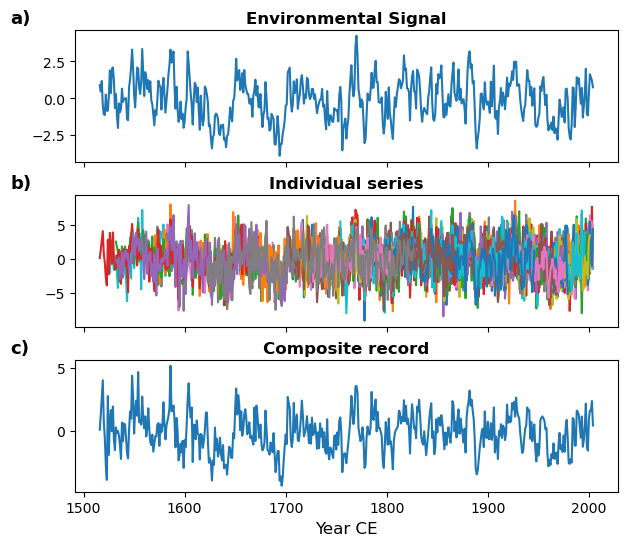

In [31]:
plt.close()
fig, axs = plt.subplots(3,1,sharex=True,figsize=(7,6),facecolor='white',gridspec_kw={'hspace': 0.25})
synth_env.plot(ax=axs[0])
synth_df.plot(ax=axs[1],legend=False)
avg_synth_ts.plot(ax=axs[2],legend=False)
letters = ['a)','b)','c)']
titles = ['Environmental Signal', 'Individual series', 'Composite record']
for i in range(3):
    axs[i].text(-0.12,1.05,letters[i],transform=axs[i].transAxes,fontsize=13, weight='bold')
    axs[i].text(0.5,1.05,titles[i],transform=axs[i].transAxes,horizontalalignment='center',fontsize=12, weight='bold')
    #axs[i].set_ylabel('Signal')
axs[-1].set_xlabel('Year CE',fontsize=12)
fig.savefig(f'img/env_comp_signal_alpha{alpha}_noise{nf}.png',dpi=300, bbox_inches='tight')
plt.show()

### Effect of changes in sample size and Rbar on variance

In [32]:
Rbars = np.round(np.arange(0,1.1,0.1),1)
sample_size = np.round(np.arange(1,60,1),0)
variance_df = pd.DataFrame(index=Rbars,columns=sample_size)
for Rbar in Rbars:
    for n in sample_size:
        inv_neff = (Rbar*(n-1) + 1)/n
        variance_df.loc[Rbar,n] = inv_neff

In [33]:
Rbars = np.round(np.arange(0,1.001,0.001),3)
sample_size = np.round(np.arange(1,60,0.1),1)
epss = pd.DataFrame(index=Rbars,columns=sample_size)
for Rbar in Rbars:
    for n in sample_size:
        eps = (n * Rbar) / ((n-1)*Rbar+1)
        epss.loc[Rbar,n] = eps

In [34]:
### Combinations of values with EPS values greater or equal than 0.85
eps085 = epss[epss>=0.85].apply(pd.Series.first_valid_index,axis=1).dropna().to_frame().reset_index().rename(columns={'index':'Rbar',0:'n'})
eps085['inv_neff'] = (eps085['Rbar']*(eps085['n']-1) + 1)/(eps085['n'])

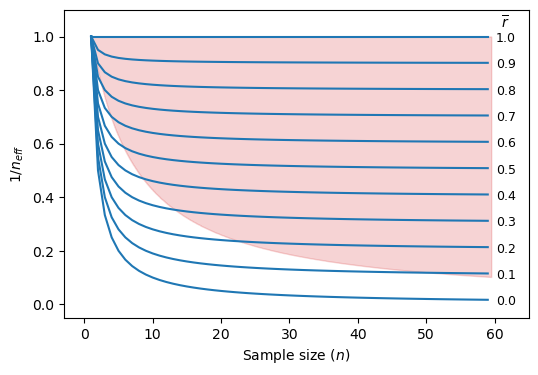

In [36]:
plt.close()
fig, axs = plt.subplots(figsize=(6,4),facecolor='white')
variance_df.T.plot(ax=axs,legend=False,color='tab:blue')
axs.fill_between(eps085['n'].values,eps085['inv_neff'].values,np.ones(len(eps085)),alpha=0.2,color='tab:red')
axs.set_xlim(-3,65)
for rb,invn in variance_df[59].items():
    axs.text(60.2,invn-0.02,str(rb),fontsize=9)
axs.set_ylabel(r'1/$n_{eff}$');
axs.set_xlabel(r'Sample size $(n)$');
axs.set_ylim(-0.05,1.1)
axs.text(61,1.03,r'$\overline{r}$');
fig.savefig(f'img/n_vs_Rbar_EPS.png',dpi=300, bbox_inches='tight');
plt.show()